# Pix2Pix Model 구현하기

- https://deep-learning-study.tistory.com/646
- color space conversion library: pytorch kornia
- matplotlib colormap: https://matplotlib.org/stable/users/explain/colors/colormaps.

<hr>

## Dataset

- train 용 Dataset은 NIR_VCIP_Challenge_dataset_v0의 RGB-Registered 폴더에 있는 372장의 RGB 사진과, NIR 폴더에 있는 그 짝이 되는 NIR이미지 372 장(https://jchenhkg.github.io/projects/NIR2RGB_VCIP_Challenge/)

- test 용 Dataset은 nirscene1 dataset의 val_A와 val_B에서 식생 위주로 동일한 파일명을 가진 60개의 이미지 짝을 추출하여 만들었음. 

In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from Research_Utils.color_space_transforms import *
transform_basic = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((256,256)),
])

transform_Norm = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.Resize((256,256)),
])

transform_to_YCbCr = transforms.Compose([
    # dataloader에서 가져올 때 이미 tensor로 변환되고 normalize도 되었으므로, 여기서는 색 공간 변환만 처리함.
    RGB2YCbCrTransform(BT="2020"),  # 사용자 정의 변환기 추가
])

transform_to_Lab = transforms.Compose([
    RGB2LAB_Transform(),
])

transform_to_Yuv = transforms.Compose([
    RGB2YUV_Transform(),
])
transform_to_xyz = transforms.Compose([
    RGB2XYZ_Transform(),
])

transform_to_ycbcr_kornia = transforms.Compose([
    RGB2YCbCr_kornia_Transform(),
])

transform_to_gray = transforms.Compose([
    RGB2Gray_Transform(),
])

transform_to_lch = transforms.Compose([
    RGB2LCH_Transform(),
])

In [3]:
from Research_Utils.RGB_NIR_Dataset import RGB_NIR_Dataset
from Research_Utils.RGB_NIR_Dataset import dataset_info

train_img_dir = r".\Datasets\RGB2NIR\train"
test_img_dir  = r".\Datasets\RGB2NIR\test"

train_ds = RGB_NIR_Dataset(train_img_dir, transform=transform_basic)
test_ds  = RGB_NIR_Dataset(test_img_dir,  transform=transform_basic)

print('\n'.join([f"{k} {v}" for k, v in dataset_info(train_ds).items()]), "\n", "-"*100)
print('\n'.join([f"{k} {v}" for k, v in dataset_info(test_ds).items()]))


keys ['dir_RGB', 'dir_NIR', 'img_filenames', 'transform']
len 372
dir_RGB .\Datasets\RGB2NIR\train\RGB
dir_NIR .\Datasets\RGB2NIR\train\NIR
transform Compose(
    ToTensor()
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
) 
 ----------------------------------------------------------------------------------------------------
keys ['dir_RGB', 'dir_NIR', 'img_filenames', 'transform']
len 60
dir_RGB .\Datasets\RGB2NIR\test\RGB
dir_NIR .\Datasets\RGB2NIR\test\NIR
transform Compose(
    ToTensor()
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
)


train_RGB.shape: torch.Size([3, 256, 256])	train_NIR.shape: torch.Size([3, 256, 256])


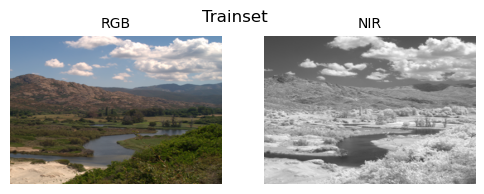

In [41]:
# 샘플 이미지 확인하기
idx = 8
train_RGB, train_NIR, _ = train_ds[idx] #5  
print(f"train_RGB.shape: {train_RGB.shape}\ttrain_NIR.shape: {train_NIR.shape}")  # C, H, W

#mean_, std_ = 0.5, 0.5
mean_, std_ = 0., 1.
samples = [ train_RGB.permute(1,2,0), train_NIR.permute(1,2,0)]

fig, ax = plt.subplots(1,2, figsize=(6,2))

for i in range(2):
    ax[i].imshow(std_*samples[i]+mean_, aspect='auto')
    ax[i].set_title("RGB" if i == 0 else "NIR", fontsize=10)
    ax[i].axis('off')

plt.suptitle("Trainset")
plt.subplots_adjust(top=0.85)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-24.832296..100.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00024769965..100.0].


sample.shape: torch.Size([1, 3, 256, 256])
ycbcr: torch.Size([1, 3, 256, 256])
lab: torch.Size([1, 3, 256, 256])
lch: torch.Size([1, 3, 256, 256])
mean_: 0.0, std_: 1.0

====== rgb: torch.Size([1, 3, 256, 256]) ======
[R] rgb[:,0].min(): 0.0235	rgb[:,0].max(): 1.0000
[G] rgb[:,1].min(): 0.0235	rgb[:,1].max(): 1.0000
[B] rgb[:,2].min(): 0.0039	rgb[:,2].max(): 1.0000


====== ycbcr: torch.Size([1, 3, 256, 256]) ======
[Y]  ycbcr[:,0].min(): 0.0238	ycbcr[:,0].max(): 1.0000
[Cb] ycbcr[:,1].min(): 0.3125	ycbcr[:,1].max(): 0.6022
[Cr] ycbcr[:,2].min(): 0.4075	ycbcr[:,2].max(): 0.5935


====== lab: torch.Size([1, 3, 256, 256]) ======
[L] lab[:,0].min():   1.6638	lab[:,0].max(): 100.0000
[A] lab[:,1].min(): -18.5282	lab[:,1].max(): 13.7732
[B] lab[:,2].min(): -24.8323	lab[:,2].max(): 47.8800

====== lch: torch.Size([1, 3, 256, 256]) ======
[L] lch[:,0].min(): 1.6638	lch[:,0].max(): 100.0000
[C] lch[:,1].min(): 0.0013	lch[:,1].max(): 48.9973
[H] lch[:,2].min(): 0.0002	lch[:,2].max(): 6.2831


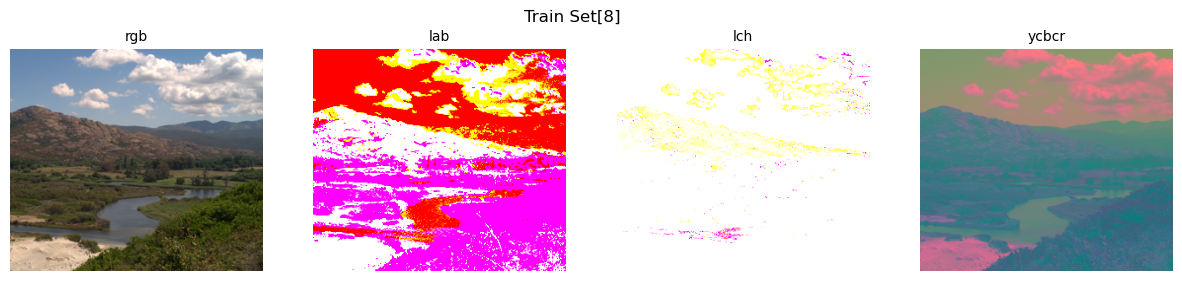

In [42]:
sample = train_RGB                      # Torch Tensor
sample = sample.unsqueeze(dim=0)        # [C, H, W] -> [B, C, H, W]
print(f"sample.shape: {sample.shape}")  # [B, C, H, W]

rgb = sample
#ycbcr = transform_to_YCbCr(sample)       # Torch Tensor [B, C, H, W]
ycbcr = transform_to_ycbcr_kornia(sample)  # Torch Tensor [B, C, H, W]
lab = transform_to_Lab(sample)             # Torch Tensor [B, C, H, W]
lch = transform_to_lch(sample)             # Torch Tensor [B, C, H, W]
print(f"ycbcr: {ycbcr.shape}")
print(f"lab: {lab.shape}")
print(f"lch: {lch.shape}")
 
# 시각화
#mean_, std_ = transform_basic.transforms[1].mean[0], transform_basic.transforms[1].std[0]
print(f"mean_: {mean_}, std_: {std_}")

rgb_img   = (rgb[0]).permute(1,2,0)  # Tensor 구조 변환 [C, H, W] => [H, W, C] <= plt.imshow()를 위한 사전 작업
print(f"\n====== rgb: {rgb.shape} ======")   
print(f"[R] rgb[:,0].min(): {rgb[:,0].min():.4f}\trgb[:,0].max(): {rgb[:,0].max():.4f}")
print(f"[G] rgb[:,1].min(): {rgb[:,1].min():.4f}\trgb[:,1].max(): {rgb[:,1].max():.4f}")
print(f"[B] rgb[:,2].min(): {rgb[:,2].min():.4f}\trgb[:,2].max(): {rgb[:,2].max():.4f}\n")

ycbcr_img = (ycbcr[0]).permute(1,2,0)  # Tensor 구조 변환 [C, H, W] => [H, W, C] <= plt.imshow()를 위한 사전 작업
print(f"\n====== ycbcr: {ycbcr.shape} ======")   
print(f"[Y]  ycbcr[:,0].min(): {ycbcr[:,0].min():.4f}\tycbcr[:,0].max(): {ycbcr[:,0].max():.4f}")
print(f"[Cb] ycbcr[:,1].min(): {ycbcr[:,1].min():.4f}\tycbcr[:,1].max(): {ycbcr[:,1].max():.4f}")
print(f"[Cr] ycbcr[:,2].min(): {ycbcr[:,2].min():.4f}\tycbcr[:,2].max(): {ycbcr[:,2].max():.4f}\n")

lab_img   = (lab[0]).permute(1,2,0)     # Tensor 구조 변환 [C, H, W] => [H, W, C] <= plt.imshow()를 위한 사전 작업
print(f"\n====== lab: {lab.shape} ======")   
print(f"[L] lab[:,0].min():   {lab[:,0].min():.4f}\tlab[:,0].max(): {lab[0,0].max():.4f}")
print(f"[A] lab[:,1].min(): {lab[:,1].min():.4f}\tlab[:,1].max(): {lab[0,1].max():.4f}")
print(f"[B] lab[:,2].min(): {lab[:,2].min():.4f}\tlab[:,2].max(): {lab[0,2].max():.4f}")


lch_img   = (lch[0]).permute(1,2,0)     # Tensor 구조 변환 [C, H, W] => [H, W, C] <= plt.imshow()를 위한 사전 작업
print(f"\n====== lch: {lch.shape} ======")   
print(f"[L] lch[:,0].min(): {lch[:,0].min():.4f}\tlch[:,0].max(): {lch[:,0].max():.4f}")
print(f"[C] lch[:,1].min(): {lch[:,1].min():.4f}\tlch[:,1].max(): {lch[:,1].max():.4f}")
print(f"[H] lch[:,2].min(): {lch[:,2].min():.4f}\tlch[:,2].max(): {lch[:,2].max():.4f}")


imgs = [std_*rgb_img+mean_, std_*lab_img+mean_, std_*lch_img+mean_, std_*ycbcr_img+mean_]
titles = ["rgb", "lab", "lch", "ycbcr"]

fig, ax = plt.subplots(1,4, figsize=(15,3))

for i in range(len(imgs)):
    ax[i].imshow(imgs[i], aspect='auto')
    ax[i].axis('off')
    ax[i].set_title(titles[i], fontsize=10)
    
plt.suptitle(f"Train Set[{idx}]")
plt.subplots_adjust(top=0.85)
plt.show()

In [43]:
# rgb_img의 원래 값 출력 (기본 transformer()적용시에 0.5, 0.5로 normalize 되어서 로드되었으므로, 역전환하여 원래 RGB 값을 출력)
print(rgb_img.shape)
print("R: ", std_*(rgb_img[0][0][0].item())+mean_) # R
print("G: ", std_*(rgb_img[0][0][1].item())+mean_) # G
print("B: ", std_*(rgb_img[0][0][2].item())+mean_) # B

torch.Size([256, 256, 3])
R:  0.3764705955982208
G:  0.5137255191802979
B:  0.658823549747467


In [44]:
# 데이터 로더 생성하기
from Research_Utils.RGB_NIR_Dataset import dataloader_info 

batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print("\n".join([f"{k} {v}" for k, v in dataloader_info(train_dl).items()]))

len(dl) 12
dl.batch_size 32
dl.num_workers 0
len(dl.dataset) 372
dl.dataset[len(dl.dataset)][0] torch.Size([3, 256, 256])
dataset_keys ['dir_RGB', 'dir_NIR', 'img_filenames', 'transform']


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [46]:
# Generator 모델 생성
from Research_Utils.Pix2Pix_Model import *

model_gen = NIR_GeneratorUNet(in_channels=3, out_channels=3).to(device)
model_dis = Discriminator(in_channels=3).to(device)

In [47]:
# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.01)
        

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [48]:
# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)
print(f"patch size: {patch}")

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))
#opt_dis = optim.SGD(model_dis.parameters(),lr=lr)
#opt_gen = optim.SGD(model_gen.parameters(),lr=lr)

patch size: (1, 16, 16)


In [ ]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 300
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

#color_space_transformer = RGB2LAB_Transform()
color_space_transformer = None

for epoch in range(num_epochs):
    for rgb, nir, _ in train_dl:  # "RGB2NIR"이므로 rgb, nir 순서로 이미지 가져옴. # torch.Size([32, 3, 256, 256])
        batch_size = nir.size(0)
                    
        # real image
        real_rgb_ = rgb.to(device)  # RGB

        if color_space_transformer is None:
            input_img = real_rgb_
        else:
            input_img = color_space_transformer(real_rgb_)

        real_nir = nir.to(device)  # NIR

        # patch label
        real_label = torch.ones(batch_size, *patch, requires_grad=False).to(device)   # torch.Size([32, 1, 16, 16]) <= [B, 1, P, P]
        fake_label = torch.zeros(batch_size, *patch, requires_grad=False).to(device)  # torch.Size([32, 1, 16, 16]) <= [B, 1, P, P]
        
        ########## generator ##########
        model_gen.zero_grad()

        fake_nir = model_gen(input_img) # 실제 RGB 사진을 입력 받아서 가짜 NIR 이미지 생성, feature extraction을 위한 UNetDown으로 들어가므로 일반적인 GAN처럼 random noize를 주지 않고 바로 real image를 입력으로 줌.
        #fake_nir = std_ * fake_nir + mean_  ## <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< try result: Bed
        # out_dis.shape = real_label.shape = fake_label.shape
        # 가짜 이미지에 대한 판별
        out_dis = model_dis(input_img, fake_nir) # 실제 입력된 이미지(real RGB)를 condition으로 주고, 생성된 가짜 NIR 이미지가 가짜인지 진짜인지를 패치 단위로 예측, # torch.Size([32, 1, 16, 16]) <= [B, 1, P, P]
        
            
        gen_loss = loss_func_gan(out_dis, real_label)  # nn.BCELoss()
        # pixel-wise loss
        pixel_loss = loss_func_pix(fake_nir, real_nir) # nn.L1Loss()

        g_loss = gen_loss + (lambda_pixel * pixel_loss)
        g_loss.backward()
        opt_gen.step()

        ########## discriminator ##########
        model_dis.zero_grad()

        # 판별자에게 진짜 이미지와 가짜 이미지를 5:5로 주어 판별자가 학습할 수 있도록 함.
        # 진짜 이미지에 대한 판별
        out_dis = model_dis(input_img, real_nir)   # condition과 실제 이미지를 주어서 Discriminator가 각 이미지별 패치 단위로 판별하도록 함함
        real_loss = loss_func_gan(out_dis, real_label)
        
        # 가짜 이미지에 대한 판별
        out_dis = model_dis(real_nir, fake_nir.detach())  
        #out_dis = model_dis(input_img, fake_nir.detach()) # <<<<<<<<<<<<<<<< try result : bed  
        fake_loss = loss_func_gan(out_dis, fake_label)      # nn.BCELoss()

        d_loss = (real_loss + fake_loss) * 0.5
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))
            
print(f"\ncolor_space_transformer: {color_space_transformer.__class__.__name__}")

Epoch: 8, G_Loss: 10.505719, D_Loss: 0.043117, time: 0.37 min
Epoch: 16, G_Loss: 9.657670, D_Loss: 0.015326, time: 0.73 min
Epoch: 24, G_Loss: 8.772943, D_Loss: 0.009796, time: 1.08 min
Epoch: 33, G_Loss: 8.156422, D_Loss: 0.006055, time: 1.44 min
Epoch: 41, G_Loss: 6.438419, D_Loss: 0.004948, time: 1.80 min
Epoch: 49, G_Loss: 6.619415, D_Loss: 0.003833, time: 2.17 min
Epoch: 58, G_Loss: 6.244247, D_Loss: 0.002834, time: 2.54 min
Epoch: 66, G_Loss: 6.283450, D_Loss: 0.002695, time: 2.90 min
Epoch: 74, G_Loss: 5.217113, D_Loss: 0.001839, time: 3.27 min
Epoch: 83, G_Loss: 6.336140, D_Loss: 0.001662, time: 3.64 min
Epoch: 91, G_Loss: 5.245324, D_Loss: 0.001322, time: 4.00 min
Epoch: 99, G_Loss: 5.572366, D_Loss: 0.001080, time: 4.37 min
Epoch: 108, G_Loss: 4.784050, D_Loss: 0.001177, time: 4.73 min
Epoch: 116, G_Loss: 5.091527, D_Loss: 0.000882, time: 5.10 min


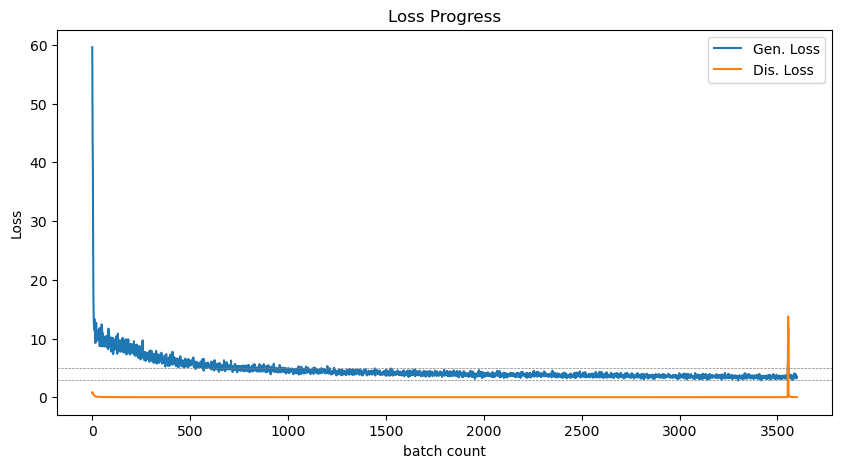

In [27]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.axhline(5.0, linestyle="--",c="gray", linewidth=0.5)
plt.axhline(3.0, linestyle="--", c="gray", linewidth=0.5)
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 모델 저장

In [28]:
# 모델 (가중치) 저장

cst_name = color_space_transformer.__class__.__name__
if "None" in cst_name:
    model_dir = f'./RGB2NIR_models/rgb'
else:
    model_dir = f'./RGB2NIR_models/{cst_name.split("2")[1]}'
    
os.makedirs(model_dir, exist_ok=True)
weights_gen_path = os.path.join(model_dir, 'weights_gen.pt')
weights_dis_path = os.path.join(model_dir, 'weights_dis.pt')

torch.save(model_gen.state_dict(), weights_gen_path)
torch.save(model_dis.state_dict(), weights_dis_path)

## Generator가 생성한 가짜 이미지 확인하기

In [ ]:
# 가중치 불러오기
weights = torch.load(weights_gen_path)
model_gen.load_state_dict(weights)

In [29]:
print(f"test_img_dir: {test_img_dir}")
#test_ds = RGB_NIR_Dataset(test_img_dir, transform=transform_basic)  # 제일 윗줄에서 train_ds 만들 때 test_ds도 함께 만들었으므로 다시 만들지 않아도 됨.
test_dl = DataLoader(test_ds, batch_size=60, shuffle=False)          # test_set에 있는 이미지의 개수가 60개이므로, batch_size=60을 주어서 모두 가져오게 함.

test_img_dir: .\Datasets\RGB2NIR\test


In [30]:
# Test set에서 이미지 한 장을 골라 color_space_transform을 적용하여 NIR 이미지를 생성하고, 정답과의 차이를 MSE로 구하는 함수
import torch.nn.functional as F

def eval(idx_, color_transformer):
    model_gen.eval()
    rgbs_valid, nirs_valid, indices = test_ds[idx_]    # torch.Size([C, H, W])
    rgbs_valid = rgbs_valid.unsqueeze(dim=0)           # torch.Size([B, C, H, W])
    nirs_valid = nirs_valid.unsqueeze(dim=0)           # torch.Size([B, C, H, W])
    print(f"rgbs_valid.shape {rgbs_valid.shape}")      # torch.Size([B, C, H, W])
    print(f"nirs_valid.shape : {nirs_valid.shape}\n")  # torch.Size([B, C, H, W])

    with torch.no_grad():
        # 모델에서 적용한 색상 공간 변환
        if color_transformer is None:
            input_imgs = rgbs_valid
        else:
            input_imgs = color_transformer(rgbs_valid)

        # NIR 이미지 생성
        gen_nirs_ = model_gen(input_imgs.to(device)).detach().cpu()
        
        print(f"input_imgs.shape: {input_imgs.shape}")
        print(f"gen_nirs_.shape : {gen_nirs_.shape}")
        
        ##### metrics #####
        mse_ = F.mse_loss(gen_nirs_, nirs_valid)
        print(f"\nmse: {mse_.item():.2f}")
    
    return gen_nirs_    

test_RGB.shape: torch.Size([1, 3, 256, 256])
test_NIR.shape: torch.Size([1, 3, 256, 256])

rgbs_valid.shape torch.Size([1, 3, 256, 256])
nirs_valid.shape : torch.Size([1, 3, 256, 256])

input_imgs.shape: torch.Size([1, 3, 256, 256])
gen_nirs_.shape : torch.Size([1, 3, 256, 256])

mse: 0.06


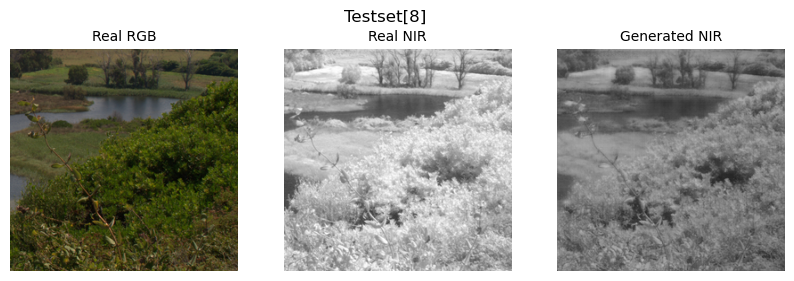

In [31]:
# Test set의 샘플 이미지 한 개개 확인하기
# dataset에서 가져온 이미지는 기본 transform만 된 상태임. (색 공간 변환 된 것은 아님!)
test_RGB, test_NIR, _ = test_ds[idx]  
test_RGB = test_RGB.unsqueeze(0)  # [C, H, W] -> [B, C, H, W]
test_NIR = test_NIR.unsqueeze(0)  # [C, H, W] -> [B, C, H, W]
print(f"test_RGB.shape: {test_RGB.shape}")  # C, H, W
print(f"test_NIR.shape: {test_NIR.shape}")  # C, H, W
print()

generated_nirs = eval(idx, color_space_transformer)

fig, ax = plt.subplots(1,3, figsize=(10,3))

imgs_ = [(std_*test_RGB[0]+mean_).permute(1,2,0), (std_*test_NIR[0]+mean_).permute(1,2,0), (std_*generated_nirs[0]+mean_).permute(1,2,0)]
titles = ["Real RGB", "Real NIR", 'Generated NIR']
for i in range(3):
    ax[i].imshow(imgs_[i], aspect="auto")
    ax[i].set_title(titles[i], fontsize=10)
    ax[i].axis("off")
    

plt.suptitle(f"Testset[{idx}]")
plt.subplots_adjust(top=0.85)
plt.show()

### Test set 전체 이미지에 대한 모델 성능 평가

In [34]:
# test set 전체 이미지에 대한 모델 평가
from torcheval.metrics import PeakSignalNoiseRatio, FrechetInceptionDistance
import torch.nn.functional as F
from Research_Utils.metrics import calculate_ssim_scores  # ssim

# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for test_rgbs, test_nirs, indices in test_dl:
        print(f"test_dl.index: {indices}\n")
        print(f"test_rgbs.shape: {test_rgbs.shape}")  # torch.Size([32, 3, 256, 256])
        print(f"test_nirs.shape: {test_nirs.shape}")
        
        if color_space_transformer is None:
            input_imgs = test_rgbs   # 기본 transform만 적용된 이미지
        else:
            input_imgs = color_space_transformer(test_rgbs)
        test_fake_nirs = model_gen(input_imgs.to(device)).detach().cpu()  # 3채널 이미지 반환 
        
        ###### loss #######
        test_mse = F.mse_loss(test_fake_nirs, test_nirs)
        print(f"\n=============================\ntest_mse : {test_mse.item():.2f}")

print(f"color space: {color_space_transformer.__call__.__name__}")
        
# 평가 메트릭릭
psnr = PeakSignalNoiseRatio()
psnr.update(test_nirs, test_fake_nirs)
psnr_score = psnr.compute().item()
print(f"test_PSNR: {psnr_score:.2f}\n")  # 높은 값일수록 우수

avg_ssim = calculate_ssim_scores(test_fake_nirs, test_nirs)
print(f"Average SSIM: {avg_ssim:.2f}")

fid = FrechetInceptionDistance()
fid.update(test_nirs.clamp(0,1), is_real=True)
fid.update(test_fake_nirs.clamp(0,1), is_real=False)
fid_distance = fid.compute()

print(f"FID: {fid_distance:.2f}")

test_dl.index: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59])

test_rgbs.shape: torch.Size([60, 3, 256, 256])
test_nirs.shape: torch.Size([60, 3, 256, 256])

test_mse : 0.02
color space: __call__
test_PSNR: 16.53



d:\Anaconda3\envs\ImageProcessing\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Average SSIM: 0.53
FID: 67.32


<hr>

### 기타 참고

##### FID

1. torcheval.metrics.FrechetInceptionDistance로 구하기
2. torch_fid.fid_score로 구하기

1. torcheval.metrics.FrechetInceptionDistance 사용법

    - FID를 구하려면 모든 픽셀의 값이 0 ~ 1의 범위에 있어야 함.

In [ ]:
# 0 ~ 1의 범위로 정규화하는 함수
def normalize_to_zero_one(imgs, min_, max_):
    imgs_normed = (imgs - min_) / (max_ - min_) 
    return imgs_normed


test_nirs_min_ = test_nirs.min().item()
test_nirs_max_ = test_nirs.max().item()
print(f"test_nirs.min(): {test_nirs_min_}\ttest_nirs.max(): {test_nirs_max_}")

test_nirs_normed      = normalize_to_zero_one(test_nirs, test_nirs_min_, test_nirs_max_)
test_fake_nirs_normed = normalize_to_zero_one(test_fake_nirs, test_nirs_min_, test_nirs_max_)

print(f"\ntest_nirs_normed      (min): {test_nirs_normed.min().item()}\t(max): {test_nirs_normed.max().item()}")
print(f"test_fake_nirs_normed (min): {test_fake_nirs_normed.min().item():.4f}\t(max): {test_fake_nirs_normed.max().item():.4f}")

In [ ]:
from torcheval.metrics import FrechetInceptionDistance 

fid = FrechetInceptionDistance()
fid.update(test_nirs.clamp(0,1), is_real=True)
fid.update(test_fake_nirs.clamp(0,1), is_real=False)
fid_distance = fid.compute()

print(f"FID: {fid_distance:.2f}")

2. torch_fid.fid_score 사용법

In [ ]:
print(test_fake_nirs.shape)
print(test_img_dir)
fake_img_dir = os.path.join(test_img_dir, "fake_nir")
print(fake_img_dir)
print(f"test img indices: {indices}")
print("Test file name:", end="\n\t")
filenames = [f"{fn}" for fn in test_ds.img_filenames]
print("\n\t".join([f"{fn}" for fn in test_ds.img_filenames]))


In [ ]:
import os 
from torchvision.utils import save_image

real_img_dir = os.path.join(test_img_dir, "NIR")         # .\Datasets\RGB2NIR\test\NIR
fake_img_dir = os.path.join(test_img_dir, "fake_nir")    # .\Datasets\RGB2NIR\test\fake_nir

os.makedirs(fake_img_dir, exist_ok=True)

for i in range(test_fake_nirs.shape[0]):
    save_image(test_fake_nirs[i], os.path.join(fake_img_dir, filenames[i]))

In [ ]:
from pytorch_fid import fid_score

def fid_compare(img_dir_pair_list):
    fid_value = fid_score.calculate_fid_given_paths(
                            paths=img_dir_pair_list, # Ensure these directories contain the saved images
                            batch_size=60,
                            device=device,
                            dims=2048, 
                            num_workers=0,
    )
    print(f"path in which images to compare: {img_dir_pair_list[0]} vs {img_dir_pair_list[1]}")
    print(f"FID value: {fid_value}")

In [ ]:
compare_nirs_dirs = [real_img_dir, fake_img_dir]
#compare_nirs_dirs = [real_img_dir, real_img_dir]
fid_compare(compare_nirs_dirs)